## Goal
To develop further capability with numerical methods for integration.

We will also have a brief introduction to the idea of numerical
approximation of derivatives, as preparation for thinking about
ordinary and partial differential equations.

## Readings
Let us list all the sections we are covering in Newman Chapter 5 **Integrals and derivatives**, including those we read last week:

    5.1 Fundamental methods for evaluating integrals

    5.2 Errors on integrals

    5.3 Choosing the number of steps

    5.4 Romberg integration*

    5.5 Higher-order integration methods

    5.7 Choosing an integration method

    5.8 Integrals over infinite ranges*

    5.10 Derivatives* -- Just read subsections 5.10.1-5.10.3 for the basics.

\* New reading this week.


In [2]:
#For colored cells, currently blue cells, black text 
#https://stackoverflow.com/questions/18024769/adding-custom-styled-paragraphs-in-markdown-cells
from IPython.core.display import HTML
def css_styling():
    styles = open("style.css", "r").read()
    return HTML(styles)
css_styling()

<div class=answer>
*This should be a blue cell with black font if you set the filepath correctly*</font>
<div/>

## Overview

There are two aspects to this week's investigations:

1.  The first is more technically oriented - we will reorient our thinking towards calculating results to a  given *tolerance*, rather than with a fixed number of steps.  We will then explore the idea of extrapolating to a more accurate answer - Romberg integration is an example of the more general approach of Richardson extrapolation, which is also applied in other contexts (in particular, solution of differential equations).

2. The second aspect is oriented towards developing savvy in the use of numerical integration.  We will develop a feel for some of the less well-behaved types of integrals which one encounters in practice, and see ways of handling integrals over infinite ranges.

This week you may use your own integration technique, or ```integrate.py``` to do this.  See some directions below the answer box for importing ```integrate.py```.  To use it, look at your work from last week, or call ```help(integrate)```.  To import the module, either you need a local copy of ```integrate.py``` in which case you can run:  

In [3]:
import integrate
import math

# benchmark function - as last week
def f_decay(x):
    return math.exp(-x)
int_decay = 1 - 1/math.e

# sample quick checks
#print(integrate.integrate(f_decay,(0,1),100)[0])           #trapezoid, 100 steps
#print(integrate.integrate(f_decay,(0,1),1000)[0])          #trapezoid, 100 steps
#print(integrate.integrate(f_decay,(0,1),100,order=2)[0])   #simpsons, 1000 steps

Or alternatively you can use the ```sys``` module (short for system) to update the filepaths that python will look for modules in.  The code for that is:  

In [4]:
#import sys
#sys.path.append("/Users/mcde2235/Box Sync/Coursework/PHY325/Spring2018/Labs/Lab4")
#import integrate_2  


**FYI: if you modify your module, you will need to restart the kernel to use the modified codes.  There are some alternative methods, but nothing elegant
[source](https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart).**

## Exercise 1: 

In Section 5.2.1, Newman describes the practical method for estimating the error in a trapezoidal rule or Simpson's rule calculation.  Try these error estimates out for the trapezoidal rule on our benchmark integral, with $20$ steps
and $200$ steps.  __How close are the estimates to the actual errors?__  What about the sign (this will matter when we get to Romberg integration)? Repeat for Simpson's rule.

In [63]:
import numpy as np

def percent_error(analytic, approx):
    return (abs(approx -analytic)/analytic*100)

approx1 = (integrate.integrate(f_decay,(0,1),20)[0])
approx2 = (integrate.integrate(f_decay,(0,1),200)[0])
approx3 = (integrate.integrate(f_decay,(0,1),20,order=2)[0])
approx4 = (integrate.integrate(f_decay,(0,1),200,order=2)[0])

analytic = (int_decay)
error_trap1 = (1/12)*((1/20)**2)*(-f_decay(0)+f_decay(1))
error_trap2 = (1/12)*((1/200)**2)*(-f_decay(0)+f_decay(1))
error_simp1 =  (1/90)*((1/20)**4)*(-f_decay(0)+f_decay(1))
error_simp2 =  (1/90)*((1/200)**4)*(-f_decay(0)+f_decay(1))

error1 = analytic - approx1
error2 = analytic - approx2
error3 = analytic - approx3
error4 = analytic - approx4



print("acutal error",error1,error2,error3,error4)
print("Euler approximate error",error_trap1,error_trap2,error_simp1,error_simp2)

acutal error -0.00013168629625837092 -1.316917282445651e-06 -2.1942099914795676e-08 -2.1946888750790094e-12
approximate error -0.00013169178308928287 -1.3169178308928286e-06 -4.3897261029760966e-08 -4.3897261029760956e-12


<div class=answer>
<div/>
The error values can be seen above.  The approximates are very close to the expected values.  The error values calculated from Euler's equations come very close to the actual error.

## Exercise 2
### Trapezoidal rule with tolerance goal (Newman's Adaptive Method)

In practice, integration with a fixed  number of *steps* is not useful for automated use.  If your code must calculate millions of integrals (or even just hundreds of integrals), and you need a certain accuracy, it is simply impractical for you to intervene and hand-pick the number of steps for each integral.  You could just choose a "really big'' number of steps for all integrals, even when they are not needed, but this will make your code impractically slow (perhaps factors of hundreds slower than it needs to be).

Following the approach outlined in Newman Section 5.3, let us write a function which uses the trapezoidal rule to calculate with $1$, $2$, $4$, $8$, $\ldots$ steps (*i.e.*, $~2^i$ steps), until the error estimate falls below a specified tolerance.  

As Newman points out, we do not need to calculate all the points from scratch in each successive iteration.  Your
function should follow's Newman's approach, *i.e.*, "reusing'' the value of the previous integral to avoid evaluating the integrand $f$ at the same point more than once.

In fact, let us see how how much of an improvement this gives. Suppose we ultimately need, say, $2^{5}$ steps.  How many times would we have to evaluate $f$ if we evaluated the integral from scratch with each iteration ($1$, $2$, $4$, $8$, $\ldots$ steps)?  How many times would we have to evaluate $f$ if we reused the prior integrals, instead?

In [6]:
def integrate_adaptive(a, b, f, accepted_error, verbose=False, max_order = 20):
    
    """This function calculates an integral from a to b using the trapeziod rule
    with number of steps N that gives an integral value accurate to the accepted error value.
    
    input(s):
    a = beginning x value of function
    b = final x value of function
    f = the function to be integrated
    accepted_error = the amount of error that we are okay with
    
    output(s):
    final_value = the final value of the integral i.e the area under the curve."""

    #print(a, b, accepted_error, f)
    N1= 1                                        #The initial value of N
    h1 = (b-a)/N1                                #The initial value of h
    current_error = 2*accepted_error             #The current error, which we try to make decently large
    I1 = h1*(0.5*f(a) + 0.5*f(b))                #I think this is for the portion that is outside of the summation
    I0 = I1                                      #Sets the previous I equal to the current I
    while abs(current_error) >= accepted_error:  #Runs while the absolute value of the current error is greater than or equal to  
                                                 #the accepted error.  
        h1 /= 2                                  #Each new value of h is equal to half of the previous value
        N1 *= 2                                  #Each new value of N is equal to twice the previous value
        I0 = I1 
        I1 = 0
        #print(I1)
        for k in range(1,N1,2):                   #Starts the value at 1, goes to N-1, in steps of 2, so that they are all odd.
            #print("k, I1", k, I1, a+k*h1)
            I1 += f(a+k*h1)                       #Calculates the new current I
                  
        I1 = 0.5*I0 + h1*I1                       #Calculates the final value using eq. 5.34
        current_error = 1/3*(I1 - I0)             #Calculates the current error using eq. 5.30
        
        if N1 > 10**max_order:
            break
        if verbose == True:                       #To be honest I just know that this is an optional argument that I set.
            print("Error = ", current_error,"I1 = ", I1,"N = ",N1,"h =", h1)     
    print("Number of steps =", N1)
    print("I1 = ", I1)
    return(I1) 

integrate_adaptive(0, 1, f_decay, 10**(-10))

Number of steps = 32768
I1 =  0.632120558877616


0.632120558877616

<div class=answer>
<div/>
f will have to evaluate 63 times if we evaluated the integral from scratch each time.  If we reused the prior integrals, we would only have to run it 6 times.

Also, it will help if your function can produce verbose output, showing the integral and error estimate at each stage, and the residual relative to a known true value (you can peek at ```romberg.py``` for ideas on how to do this).

You can name your function ```integrate_adaptive```, and either embed it in this notebook in a code cell (as usual) or add it to the ```integrate.py``` which I gave you last week.   

Test your new function out on the same benchmark integral
$$
\int_0^1 e^{-x}\,dx
$$
as last week, and see how many iterations $i$ (and thus steps $2^i$) are
required to achieve a tolerance of $10^{-10}$.

<div class=answer>
<div/>
It runs only 6 times.  Yay!

## Exercise 3
### Romberg integration

In the interest of time, I have gone ahead and provided you with code for Romberg integration in ```romberg.py```.  It is basically just a straightforward extension of what you just coded for the trapezoidal rule.  (That is, as with most code, it is straightforward in *retrospect*, once it is written...)

First, try the function ```romberg.romberg``` on our benchmark integral.  Enable the verbose output (```verbose=True```), and provide the function with the true value (```reference=...```) so it can print the residual.  Let us try for a tolerance of $10^{-10}$ again.

In [7]:
import romberg

print(romberg.romberg(f_decay, (0,1), 10**(-10), verbose = True, reference = int_decay))

integrating on range (0, 1)
  reference value +6.32121e-01

R(0,0) +6.839397205857212e-01 ... residual -5.1819e-02

R(1,0) +6.452351901491773e-01 epsilon(1,0) -1.2902e-02 ... residual -1.3115e-02
R(1,1) +6.323336800036626e-01 ... residual -2.1312e-04

R(2,0) +6.354094290276936e-01 epsilon(2,0) -3.2753e-03 ... residual -3.2889e-03
R(2,1) +6.321341753205323e-01 epsilon(2,1) -1.3300e-05 ... residual -1.3616e-05
R(2,2) +6.321208750083236e-01 ... residual -3.1618e-07

R(3,0) +6.329434182104802e-01 epsilon(3,0) -8.2200e-04 ... residual -8.2286e-04
R(3,1) +6.321214146047424e-01 epsilon(3,1) -8.5071e-07 ... residual -8.5578e-07
R(3,2) +6.321205638903564e-01 epsilon(3,2) -4.9384e-09 ... residual -5.0618e-09
R(3,3) +6.321205589519759e-01 ... residual -1.2342e-10

R(4,0) +6.323263138444998e-01 epsilon(4,0) -2.0570e-04 ... residual -2.0576e-04
R(4,1) +6.321206123891729e-01 epsilon(4,1) -5.3481e-08 ... residual -5.3561e-08
R(4,2) +6.321205589081349e-01 epsilon(4,2) -7.9083e-11 ... residual -7.9577e

How does the number of steps (and thus the number of points at which the integrand must be evaluated) compare to the number you needed before, with the trapezoidal rule?

<div class=answer>
<div/>
The romberg method only needs 5 steps.  The trapezoid rule needed 63 steps.  Quite the difference.

Here is an interesting observation, which I think might make Romberg extrapolation fit in better with what we have already seen.  We now seem to have two ways of going to higher order - the good old-fashioned way of using higher-order polynomials to go through the points (Newton-Cotes) or this new clever Romberg extrapolation way.
You might have noticed that:
1. the trapezoidal rule had an error of order $O(h^2)$, 

2. Simpson's rule  had an error of order $O(h^4)$, and now 

3. the first Romberg extrapolated value $R_{i,1}$ also has an error of order $O(h^4)$

    **Caution:** I am following the $0$-based convention that $R_{i,0}$ is the trapezoidal rule value, $R_{i,1}$ is the first extrapolation, *etc.*  Note that Newman uses $1$-based numbering, starting with $R_{i,1}$ for the trapezoidal rule, *etc.*, instead.

Might the first Romberg extrapolated value actually *be* Simpson'a rule???  Or does it just have an error which happens to be of the same order?  

More concretely...  Go ahead and do Simpson's rule calculations with $2^i$ steps, and compare with the first extrapolated values in the Romberg method.  Are they the same or different?  

In [8]:
N = [1,2,3,4,5]
for i in N:
    integral = integrate_adaptive()
    print(integral)    

TypeError: integrate_adaptive() missing 4 required positional arguments: 'a', 'b', 'f', and 'accepted_error'

<div class=answer>
<div/>
They are the same values.  Romberg's first extrapolated values are the same as the Simpson's values.

Explain your result in terms of the
formulas for Simpson's rule, the trapezoidal rule, and Romberg
extrapolation.

<div class=answer>
<div/>
The trapezoid rule is the simplest, it fits trapeziods underneath a curve, and adds their area to find an approximate value of an integral.  Romberg uses the trapezoid rule for a portion of its calculation.  Simpson's rule is the same as the trapezoid rule, except that it uses quadratic curves instead of trapezoids.  The first extrapolated Romberg values are the same as the Simpsons values because the 

## Exercise 4
### Life gets messy

** Note:** You may find your output in this section to be too much information.  You do not need to print out the entirety of the verbose output for all these
calculations.  

Now that we are equipped with all these ultrapowerful integration
algorithms, we should be ready to face any problem which is thrown at
us, right???  So calculating the area of a circle should be a piece of
cake, right?

*Ha! Since when has ```pi``` been cake?*

Plot the graph of the function $f(x)=\sqrt{1-x^2}$ on $[-1,1]$.

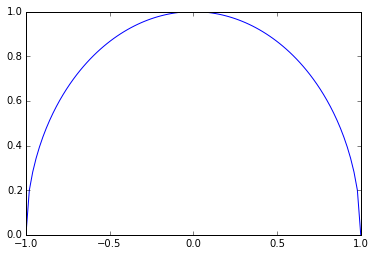

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def area_half_circle(t):
    return math.sqrt(1-(t**2))

y = []
x = []

for t in np.linspace(-1,1,100):
    x.append(t)
    y.append(area_half_circle(t))
    
plt.plot(x, y)

What is the analytically known value of the integral
$$
\int_{-1}^{1}\sqrt{1-x^2}\,dx?
$$
**Note:** You may quote results from elementary school without further proof.

<div class=answer>
<div/>
The answer is half of pi times r squared.  Which means that the area under this curve is pi/2.

To reach a tolerence of $10^{-10}$ with the trapezoidal rule, how many
iterations (and thus steps) are required?  Do you find that the
residual of your 
calculated result, relative to the known true value, is consistent with the
tolerance you asked for?  How about with Romberg extrapolation?

In [10]:
print("Actual value =", math.pi/2)
integrate_adaptive(-1, 1, area_half_circle, 10**(-10), verbose=False, max_order = 30)
print(romberg.romberg(area_half_circle, (-1,1), 10**(-10), verbose = True, reference = math.pi/2))


Actual value = 1.5707963267948966
Number of steps = 8388608
I1 =  1.570796326726514
integrating on range (-1, 1)
  reference value +1.57080e+00

R(0,0) +0.000000000000000e+00 ... residual +1.5708e+00

R(1,0) +1.000000000000000e+00 epsilon(1,0) +3.3333e-01 ... residual +5.7080e-01
R(1,1) +1.333333333333333e+00 ... residual +2.3746e-01

R(2,0) +1.366025403784439e+00 epsilon(2,0) +1.2201e-01 ... residual +2.0477e-01
R(2,1) +1.488033871712585e+00 epsilon(2,1) +1.0313e-02 ... residual +8.2762e-02
R(2,2) +1.498347240937868e+00 ... residual +7.2449e-02

R(3,0) +1.497854534051220e+00 epsilon(3,0) +4.3943e-02 ... residual +7.2942e-02
R(3,1) +1.541797577473481e+00 epsilon(3,1) +3.5842e-03 ... residual +2.8999e-02
R(3,2) +1.545381824524207e+00 epsilon(3,2) +7.4658e-04 ... residual +2.5415e-02
R(3,3) +1.546128405216054e+00 ... residual +2.4668e-02

R(4,0) +1.544909572178587e+00 epsilon(4,0) +1.5685e-02 ... residual +2.5887e-02
R(4,1) +1.560594584887709e+00 epsilon(4,1) +1.2531e-03 ... residual +1.

<div class=answer>
<div/>
For the trapezoid rule, we need 8388608 steps in order to reach our tolerance. They are accurate to the answer I asked for.  Both of them. 

Looking back at the
Euler-Maclaurin formula, why might we expect this integral to be
problematic?

**Comment:**  Our whole analysis is based on the idea that the error in the trapezoidal rule is $O(h^2)$.  But occasionally the coefficient on $h^2$ can be important...


<div class=answer>
<div/>
There is an error because you end up deviding by zero if you are using the Euler-Maclaurin formula.

There is a further lesson to be learned here.   Sometimes just throwing numerical methods at a problem is not enough.  A little forethought can allow us to
transform the problem into one which is more amenable to numerical solution.  Try
making the trigonometric substitution $x=\cos u$.

You should have just found that the integral an equivalent to
$\int_0^\pi \sin^2 u\,du$.  Do we still expect trouble?  (Explain.)  

<div class=answer>
<div/>
You still get a zero, but you are no longer dividing by zero.  You have to calculate to a higher power in order to fix this.

How does this transformed integral fare with the Romberg method?

In [27]:
def fsin(x):
    return math.sin(x)**2


I = romberg.romberg(fsin, (0,math.pi),10**(-10), verbose = True)
print("Area = ", I)

integrating on range (0, 3.141592653589793)

R(0,0) +2.355817157679958e-32

R(1,0) +1.570796326794897e+00 epsilon(1,0) +5.2360e-01
R(1,1) +2.094395102393195e+00

R(2,0) +1.570796326794897e+00 epsilon(2,0) +0.0000e+00
R(2,1) +1.570796326794897e+00 epsilon(2,1) -3.4907e-02
R(2,2) +1.535889741755010e+00

R(3,0) +1.570796326794897e+00 epsilon(3,0) +7.4015e-17
R(3,1) +1.570796326794897e+00 epsilon(3,1) +1.4803e-17
R(3,2) +1.570796326794897e+00 epsilon(3,2) +5.5407e-04
R(3,3) +1.571350399573308e+00

R(4,0) +1.570796326794897e+00 epsilon(4,0) +0.0000e+00
R(4,1) +1.570796326794897e+00 epsilon(4,1) +0.0000e+00
R(4,2) +1.570796326794897e+00 epsilon(4,2) -7.0490e-18
R(4,3) +1.570796326794897e+00 epsilon(4,3) -2.1728e-06
R(4,4) +1.570794153960472e+00

R(5,0) +1.570796326794897e+00 epsilon(5,0) +0.0000e+00
R(5,1) +1.570796326794897e+00 epsilon(5,1) +0.0000e+00
R(5,2) +1.570796326794897e+00 epsilon(5,2) +0.0000e+00
R(5,3) +1.570796326794897e+00 epsilon(5,3) +0.0000e+00
R(5,4) +1.570796326794897e+00 

<div class=answer>
<div/>
This transformed integral does well.  It only requires 7 steps to get an answer accurate to our tolerance value.  

## Exercise 5
### Life continues to be messy: Oscillatory integrands

One perpetual bane of physicists' existence is highly oscillator
integrands.  

Let us look at the integral
$$
\int_0^{2\pi} e^x \sin 100x \,dx.
$$
First, plot the integrand.  Comment on why it might be problematic.
Can you speculate on how many slices might be needed for successful evaluation?

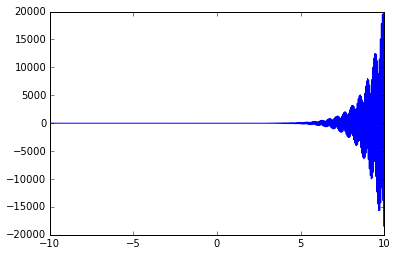

In [36]:
def f2(z):
    return math.exp(z)*math.sin(100*z)

x = []
y = []

for t in np.linspace(-10,10,1000):
    x.append(t)
    y.append(f2(t))
    
plt.plot(x,y)
plt.show()


<div class=answer>
<div/>
This might be problematic because the fuction changes direction so quickly, and so many times.  For a successful calculation, I am exepecting a need for several thousand, if not million slices.

Then, see how Romberg fares on this integral.  Comment.

In [37]:
I = romberg.romberg(f2, (0,2*math.pi), 10**(-10), verbose = True)
print(I)

integrating on range (0, 6.283185307179586)

R(0,0) +6.609362413411554e-12

R(1,0) +3.447489430260185e-12 epsilon(1,0) -1.0540e-12
R(1,1) +2.393531769209728e-12

2.3935317692097285e-12


<div class=answer>
<div/>
It seems to fare well considering it only takes 2 steps.  I am not sure how accurate this is.  The number it outputs makes sense looking at the graph.  There seems to be as much area above the graph as below it.

Now try the integral
$$
\int_0^{2\pi} e^x \sin 128x \,dx.
$$
See how Romberg fares on this integral, and comment on why.
Please attach your plot of the integrand.

In [38]:
def f3(z):
    return math.exp(z)*math.sin(128*z)

I = romberg.romberg(f3, (0,2*math.pi), 10**(-10), verbose = True)
print(I)

integrating on range (0, 6.283185307179586)

R(0,0) -5.274161174863635e-11

R(1,0) -2.751039172392076e-11 epsilon(1,0) +8.4104e-12
R(1,1) -1.909998504901557e-11

-1.909998504901557e-11


<div class=answer>
<div/>
It only takes 2 iterations to perform.  This might be because the actual integral is almost zero.

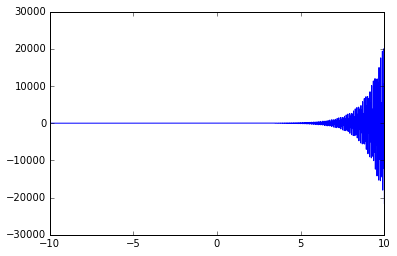

In [39]:
x = []
y = []

for t in np.linspace(-10,10,1000):
    x.append(t)
    y.append(f3(t))
    
plt.plot(x,y)
plt.show()

## Exercise 6
### Integrals over infinite ranges

Let us start by reproducing Newmans's Example 5.3 (on page 180).  But please ignore Newman's code for Gaussian integration.  Instead, we will continue to use our own Romberg integration function.

Integrands which involve the Gaussian $e^{-x^2}$ show up throughout
physics.  The basic Gaussian integral has a simple known value, so we
will use it as our test case (as we used last week ):
$$
\int_{-\infty}^\infty e^{-x^2}\,dx=\sqrt{\pi}.
$$

The integrand is symmetric, so we are free to consider just one half
($\int_{0}^\infty e^{-x^2}\,dx$), as Newman uses for his example, then
double the result.  Let us transform this integral according
to (5.67), to make sure we see how Newman got his expression.

**Sorry about the
overloading of Gauss's name. A "Gaussian integral" is an integral of
the Gaussian function.  "Gaussian integration" is integration by Gaussian
quadrature.  The two are not particularly related.**

Now try to evaluate the transformed integral using the Romberg
method.  What problem do you encounter, and how can you fix it?
It will help to make a plot of the integrand.

**Hint:** From looking at the plot,  what is the integrand's limit as $z\rightarrow 1$?


In [18]:
from math import exp

def f(z):
    return exp(-z**2/(1-z)**2)/(1-z)**2

I = romberg.romberg(f, (0,1, 10**(-10), verbose = True)
print(I)

SyntaxError: invalid syntax (<ipython-input-18-3dc02b292133>, line 6)

<div class=answer>
<div/>
You encounter a problem because you end up dividing by zero.  To fix this, just 1-(1**-10) instead of simply 1.  This will prevent you from dividing by zero.

Finally, how does the Romberg method fare on the integral? Explain.

In [20]:
from math import exp

def f(z):
    return exp(-z**2/(1-z)**2)/(1-z)**2

I = romberg.romberg(f, (0,1-10**(-10)), 10**(-10), verbose = True)
print("Analytic value = ", 0.5*math.sqrt(math.pi))
print("Romberg value = ", I)

integrating on range (0, 0.9999999999)

R(0,0) +4.999999999500000e-01

R(1,0) +9.857588823914606e-01 epsilon(1,0) +1.6192e-01
R(1,1) +1.147678509871947e+00

R(2,0) +8.910794433893940e-01 epsilon(2,0) -3.1560e-02
R(2,1) +8.595196303887052e-01 epsilon(2,1) -1.9211e-02
R(2,2) +8.403090384231556e-01

R(3,0) +8.840312978302247e-01 epsilon(3,0) -2.3494e-03
R(3,1) +8.816819159771683e-01 epsilon(3,1) +1.4775e-03
R(3,2) +8.831594016830658e-01 epsilon(3,2) +6.8016e-04
R(3,3) +8.838395661792549e-01

R(4,0) +8.855767607479196e-01 epsilon(4,0) +5.1515e-04
R(4,1) +8.860919150538178e-01 epsilon(4,1) +2.9400e-04
R(4,2) +8.863859149922610e-01 epsilon(4,2) +5.1214e-05
R(4,3) +8.864371294892324e-01 epsilon(4,3) +1.0187e-05
R(4,4) +8.864473160120165e-01

R(5,0) +8.860641650845688e-01 epsilon(5,0) +1.6247e-04
R(5,1) +8.862266331967851e-01 epsilon(5,1) +8.9812e-06
R(5,2) +8.862356144063162e-01 epsilon(5,2) -2.3857e-06
R(5,3) +8.862332286827297e-01 epsilon(5,3) -7.9961e-07
R(5,4) +8.862324290717238e-01 epsil

<div class=answer>
<div/>
Looking at the values above, Romberg does very well.

Plot your transformed integrand.

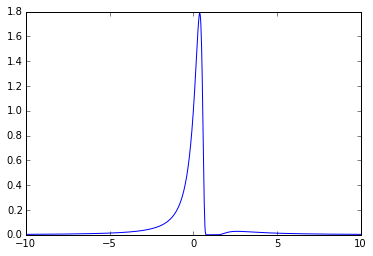

In [21]:
x = []
y = []

for t in np.linspace(-10,10,1000):
    x.append(t)
    y.append(f(t))
    
plt.plot(x,y)
plt.show()

## Numerical differentiation

** Newman Exercise 5.15 **

Create a user-defined function ```f(x)``` that returns the value $1 + \frac{1}{2} \tanh(2x)$, then use a central difference to calculate the derivative of the function in the range $-2\le x\le2$.  Calculate an analytic formula for the derivative and make a graph with your numerical result and the analytic answer on the same plot.  It may help to plot the exact answer as lines and the numerical one as dots.  

**Hint:** In Python the ```tanh``` function is found in the ```math``` package, and it's called simply ```tanh```.

Please attach your code and plots.


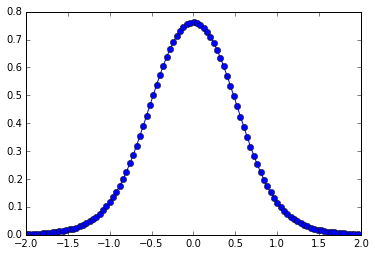

In [60]:
def f(x):
    return 1 + 0.5*math.tanh(2*x)


def dApprox(f,y,h):
    return (f(y + h/2)-f(y - h/2))/h

def dAnalytic(x):
    1/(math.cosh(2*x))**2
h = 1**(-10)
x = []
y1 = []
y2 = []

for t in np.linspace(-2,2,1000):
    x.append(t)
    y1.append(dAnalytic(t))
    y2.append(dApprox(f,t,h))

#print(len(y2))
#print(len(x))
plt.plot(x,y2, "o-", markevery = 10)
plt.plot(x,y1, "--")
plt.show()